# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,1.129995,-1.0
1,6.404755,1.0
2,2.470036,1.0
3,4.587886,1.0
4,3.151990,1.0
...,...,...
995,2.738020,1.0
996,2.967004,1.0
997,4.958859,1.0
998,0.941998,1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model
Simplest usage of HSSM, only data needs to be provided.

In [3]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

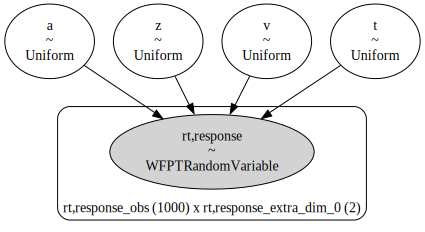

In [4]:
simple_ddm_model.graph()

In [5]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'a_interval__': array(0.5039406, dtype=float32), 't_interval__': array(0.26734573, dtype=float32), 'z_interval__': array(-0.92799604, dtype=float32), 'v_interval__': array(-0.38232106, dtype=float32)}

Logp initial evaluation results:
{'a': -1.45, 't': -1.4, 'z': -1.59, 'v': -1.42, 'rt,response': -inf}
You can call `model.debug()` for more details.

In [ ]:
az.plot_trace(simple_ddm_model.traces);

In [ ]:
az.summary(simple_ddm_model.traces)

In [ ]:
simple_ddm_model.model.predict()

## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [10]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

,rt,response
0,1.226994,1.0
1,1.282994,1.0
2,1.348993,1.0
3,0.841999,1.0
4,1.440991,1.0
...,...,...
995,1.317993,1.0
996,1.313993,1.0
997,1.846007,1.0
998,2.975003,-1.0


This creates a default angle model using pytensor

In [11]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 3.0)	bounds: (0.3, 3.0)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0010000000474974513, upper: 2.0)	bounds: (0.001, 2.0)
theta ~ Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)	bounds: (-0.1, 1.3)

In [12]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, t, z, theta, v]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 58 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

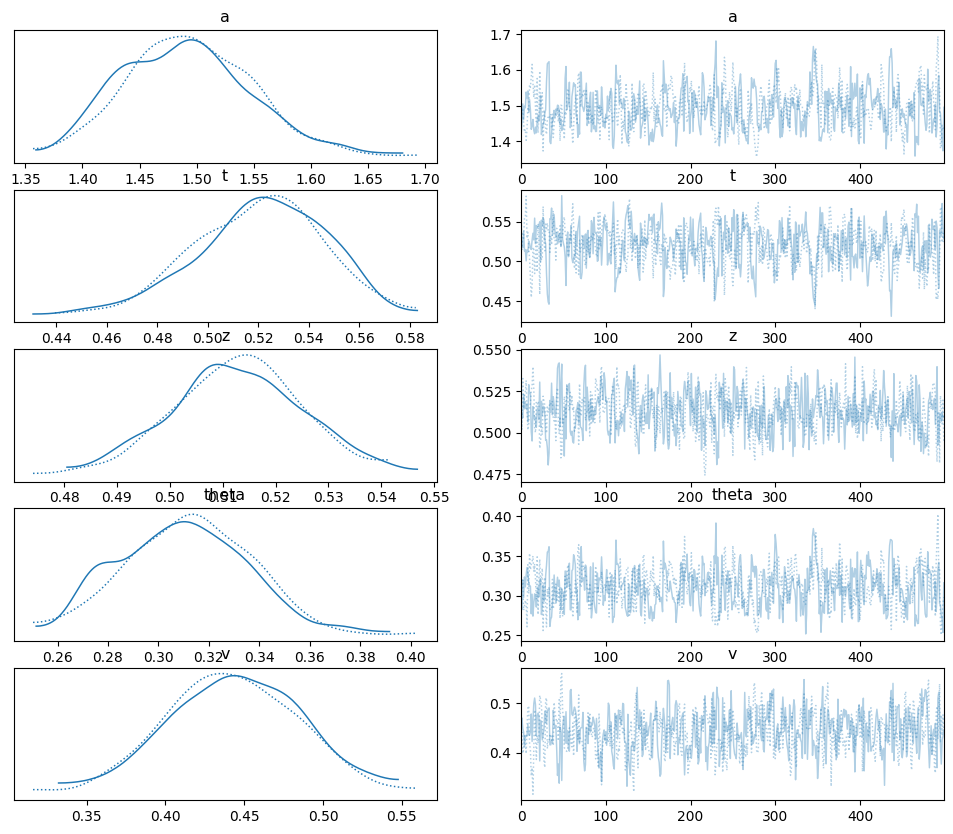

In [13]:
az.plot_trace(angle_model.traces);

#### Sampling the angle model using jax

In [14]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

Compiling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.669508
Sampling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
sample: 100%|█████████████████████████████████████████| 2000/2000 [00:34<00:00, 58.59it/s, 31 steps of size 1.91e-01. acc. prob=0.95]
/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, a

Sampling time =  0:02:05.334274
Transforming variables...
Transformation time =  0:00:00.092612


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [19]:
az.summary(angle_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.485,0.055,1.384,1.591,0.001,0.001,1485.0,1622.0,1.0
t,0.523,0.024,0.476,0.566,0.001,0.000,1732.0,2023.0,1.0
z,0.513,0.012,0.489,0.535,0.000,0.000,1916.0,2171.0,1.0
theta,0.308,0.026,0.260,0.358,0.001,0.000,1546.0,1724.0,1.0
v,0.445,0.042,0.368,0.522,0.001,0.001,1884.0,2057.0,1.0


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [2]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.2, 0.5, size=1000)
y = np.random.uniform(0.1, 0.4, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [3]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [4]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,5.994784,1,0.261986,0.373687
1,1.973013,1,0.247089,0.103501
2,1.065996,1,0.410770,0.398337
3,1.004997,1,0.388903,0.378071
4,1.323993,1,0.263253,0.379604
...,...,...,...,...
995,1.256994,1,0.354806,0.361988
996,4.638883,1,0.251597,0.293014
997,0.896998,1,0.233911,0.217213
998,4.290908,1,0.211400,0.309101


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [5]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

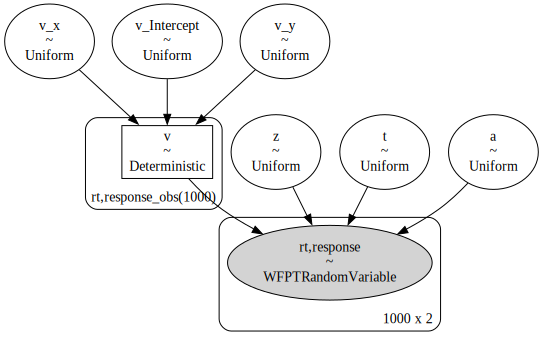

In [6]:
model_reg_v.graph()

In [16]:
trace_reg_v = model_reg_v.sample(cores=1, chains=2, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, z, t, v_Intercept, v_x, v_y]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>]],
      dtype=object)

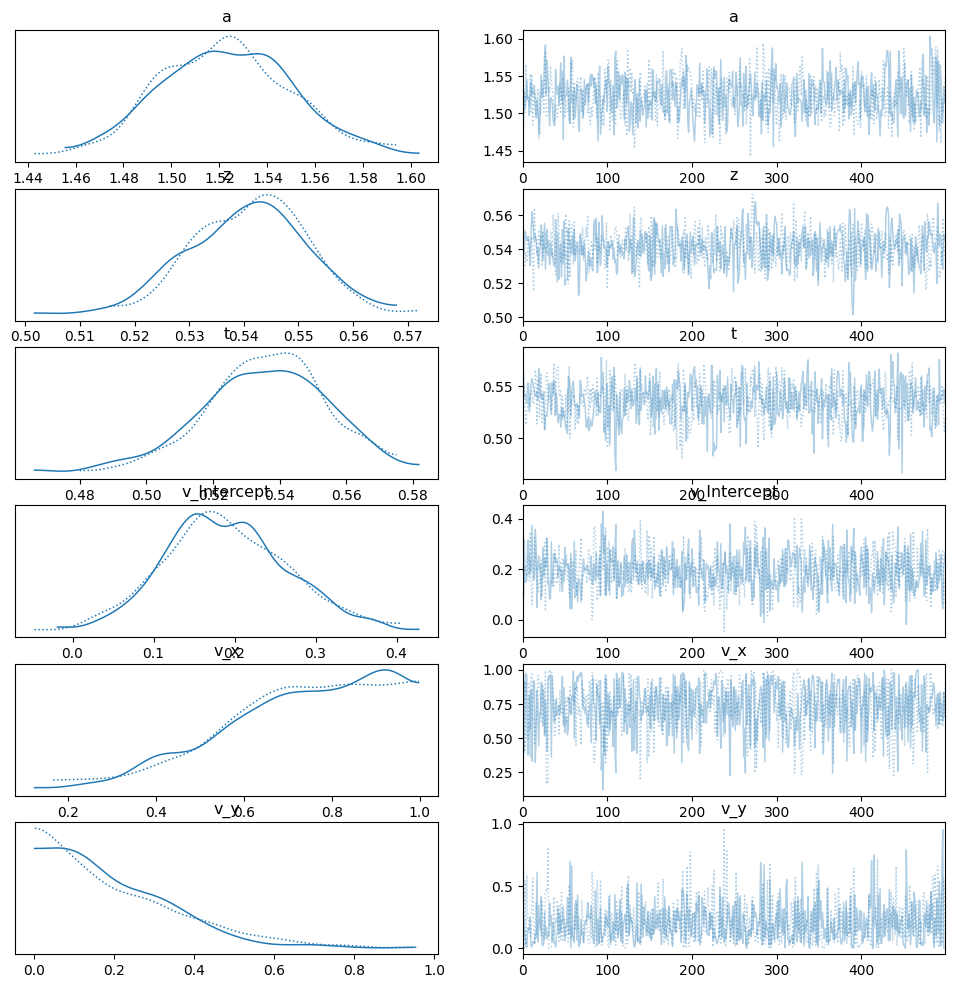

In [17]:
az.plot_trace(model_reg_v.traces)

In [18]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.523,0.027,1.472,1.573,0.001,0.001,747.0,628.0,1.00
z,0.541,0.010,0.522,0.559,0.000,0.000,837.0,642.0,1.00
t,0.536,0.018,0.503,0.570,0.001,0.000,720.0,619.0,1.00
v_Intercept,0.190,0.076,0.050,0.338,0.002,0.002,943.0,735.0,1.00
v_x,0.728,0.182,0.406,0.999,0.006,0.004,834.0,474.0,1.00
v_y,0.204,0.165,0.001,0.492,0.005,0.004,1096.0,547.0,1.01


In [19]:
new_data = pd.DataFrame(
    {
        "x": np.random.uniform(0.2, 0.5, size=1000),
        "y": np.random.uniform(0.1, 0.4, size=1000),
    }
)

In [26]:
posterior = model_reg_v.model.predict(model_reg_v.traces, data=new_data, inplace=False)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>],
       [<Axes: title={'center': 'rt,response_mean'}>,
        <Axes: title={'center': 'rt,response_mean'}>]], dtype=object)

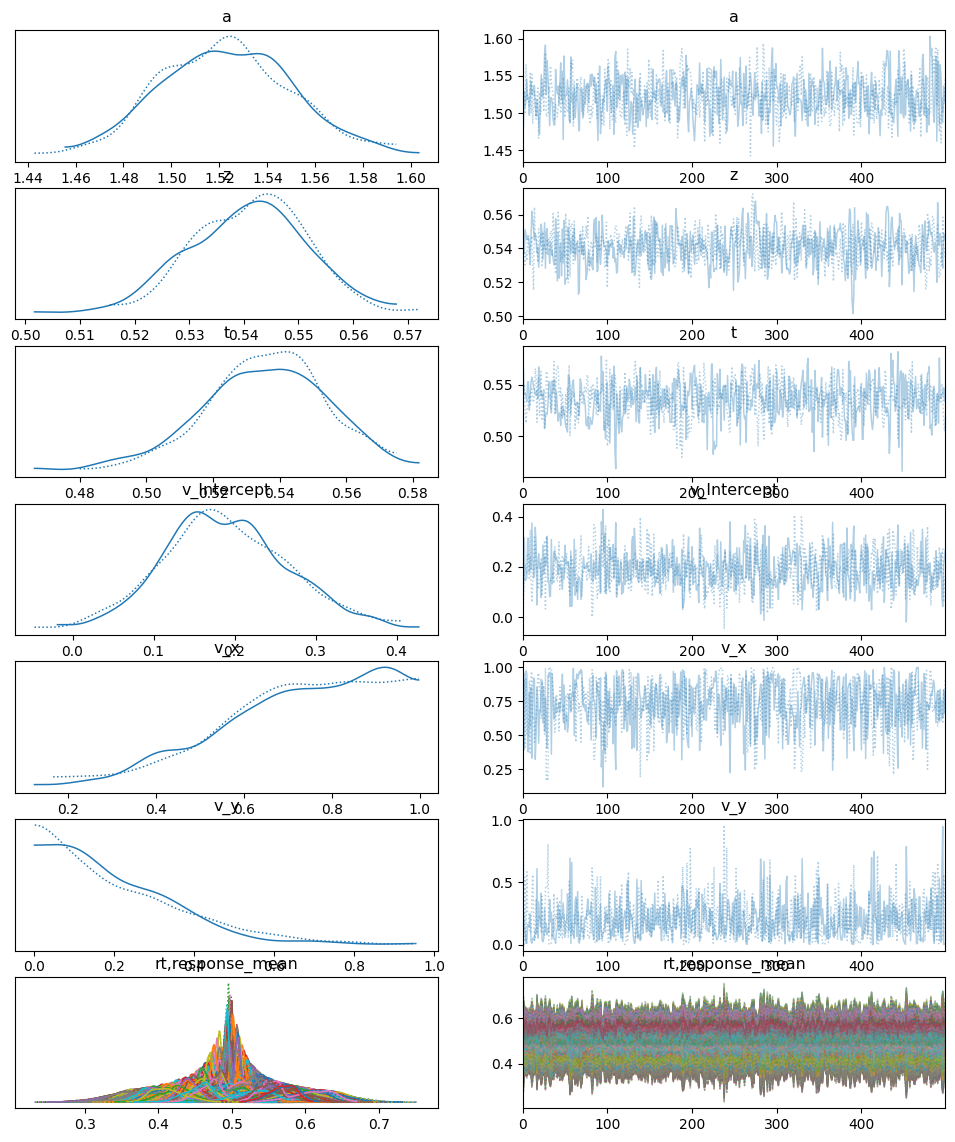

In [27]:
az.plot_trace(posterior)

In [28]:
posterior = model_reg_v.model.predict(
    model_reg_v.traces, data=new_data, inplace=False, kind="pps"
)

KeyError: 'a'

In [29]:
model_reg_v.traces.posterior

<xarray.Dataset>
Dimensions:      (chain: 2, draw: 500)
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    a            (chain, draw) float32 1.524 1.48 1.529 ... 1.509 1.52 1.548
    z            (chain, draw) float32 0.5494 0.5503 0.5369 ... 0.5408 0.5331
    t            (chain, draw) float32 0.5374 0.5651 0.5403 ... 0.505 0.5211
    v_Intercept  (chain, draw) float64 0.1589 0.09438 0.316 ... 0.1545 0.1623
    v_x          (chain, draw) float32 0.7838 0.959 0.3921 ... 0.6587 0.912
    v_y          (chain, draw) float32 0.2688 0.2823 0.1483 ... 0.4493 0.07533
Attributes:
    created_at:                  2023-05-19T16:41:40.261104
    arviz_version:               0.14.0
    inference_library:           pymc
    inference_library_version:   5.3.1
    sampling_time:               20.88836097717285
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.10.0

#### Case 2: adding initval to priors along with lower and upper.

- v is a parent
- x is a feature from the dataset_reg_v

Adding initval is optional.

In [33]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [34]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 1.0)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
sv = 0.0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

In [35]:
samples_two = hssm_include_val.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, t, z, v_Intercept, v_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [36]:
az.summary(samples_two)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.502,0.028,1.447,1.551,0.001,0.000,2989.0,2774.0,1.0
t,0.542,0.019,0.504,0.577,0.000,0.000,2651.0,2688.0,1.0
z,0.519,0.014,0.494,0.546,0.000,0.000,2549.0,2670.0,1.0
v_Intercept,0.531,0.069,0.407,0.657,0.001,0.001,3624.0,2848.0,1.0
v_x,0.266,0.177,-0.055,0.500,0.003,0.002,3446.0,2038.0,1.0


#### Case 3: not specifying parent v in the include parameter. 

The parent is v by default, specifying it is not mandatory. 

In [37]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [38]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

a ~ 1 + x
	Link: identity
	bounds: (0.3, 2.5)
	Intercept ~ Uniform(lower: 0.0, upper: 1.0, initval: 0.5)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
sv = 0.0
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

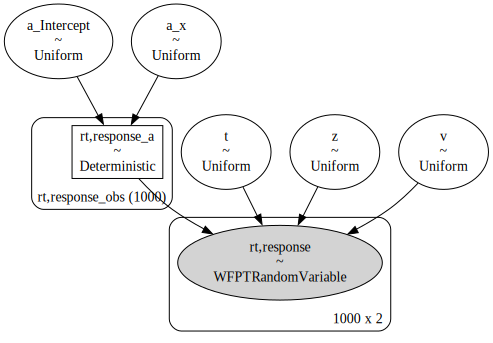

In [39]:
hssm_include_val.graph()

In [42]:
samples_three = hssm_include_val.sample(draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, z, v, a_Intercept, a_x]


Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [43]:
az.summary(samples_three)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.657,0.005,0.649,0.666,0.000,0.000,976.0,1062.0,1.00
z,0.505,0.011,0.485,0.527,0.000,0.000,939.0,869.0,1.01
v,0.462,0.029,0.409,0.518,0.001,0.001,1132.0,1032.0,1.00
a_Intercept,1.059,0.040,0.986,1.135,0.001,0.001,1267.0,908.0,1.01
a_x,-0.170,0.116,-0.390,0.039,0.003,0.003,1267.0,894.0,1.01
...,...,...,...,...,...,...,...,...,...
"rt,response_a[995]",0.979,0.014,0.953,1.004,0.000,0.000,1270.0,924.0,1.01
"rt,response_a[996]",1.005,0.004,0.998,1.012,0.000,0.000,1259.0,863.0,1.01
"rt,response_a[997]",1.005,0.004,0.998,1.012,0.000,0.000,1259.0,863.0,1.01
"rt,response_a[998]",0.983,0.011,0.963,1.004,0.000,0.000,1272.0,924.0,1.01


#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [ ]:
hssm_include_list.model

In [ ]:
hssm_include_list.graph()

In [ ]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [ ]:
samples_three = hssm_include_list.sample(draws=100, tune=100)